In [88]:
# !pip install datasets==1.6.2
# !pip install pororo
# !pip install python-mecab-ko
# !pip install seaborn
# !pip install matplotlib
# !pip install gensim

In [12]:
ner('유령은 어느 행성에서 왔는가')


[('유령', 'ARTIFACT'),
 ('은', 'O'),
 (' ', 'O'),
 ('어느', 'O'),
 (' ', 'O'),
 ('행성에서', 'O'),
 (' ', 'O'),
 ('왔는가', 'O')]

In [16]:
mecab.pos('외상후스트레스장애가 있다')

[('외상', 'NNG'),
 ('후스', 'NNP'),
 ('트레스', 'NNP'),
 ('장애', 'NNG'),
 ('가', 'JKS'),
 ('있', 'VA'),
 ('다', 'EC')]

In [1]:
import json
import zipfile
from datasets import load_from_disk
from collections import OrderedDict
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from pororo import Pororo
from konlpy.tag import Mecab

In [2]:
train_dataset = load_from_disk('/opt/ml/code/data/train_dataset/train')
print(train_dataset)

Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 3952
})


In [3]:
valid_dataset = load_from_disk('/opt/ml/code/data/train_dataset/validation')
print(valid_dataset)

Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 240
})


In [4]:
test_dataset = load_from_disk('/opt/ml/code/data/test_dataset/validation')
print(test_dataset)

Dataset({
    features: ['id', 'question'],
    num_rows: 600
})


In [5]:
how_sudo = load_from_disk('/opt/ml/code2/data/how')
print(how_sudo)

Dataset({
    features: ['answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 657
})


In [6]:
why_sudo = load_from_disk('/opt/ml/code2/data/why')
print(why_sudo)

Dataset({
    features: ['answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 276
})


In [7]:
where_sudo = load_from_disk('/opt/ml/code2/data/where')
print(where_sudo)

Dataset({
    features: ['answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 6063
})


In [41]:
dummy_sudo = load_from_disk('/opt/ml/code2/data/sudo/DUMMY')
print(dummy_sudo)

Dataset({
    features: ['answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 24
})


In [9]:
# 대상 인물 시간 장소 방법 원인

In [10]:
mecab = Mecab()


In [11]:
ner = Pororo(task="ner", lang="ko")


In [12]:
class Tags():
    def __init__(self, data, answer=True):
        question = data['question']
        answer = [ans['text'][0] for ans in data['answers']]
        df = pd.DataFrame(zip(question, answer), columns=['question', 'answer'])
        df['tag'] = None
        
        self.df = df
    
    def who(self):
        kw_who_end1 = ['사람', '인물', '여자', '남자', '이는', '자는', '대상', '상대',
                       '직책', '직업', '직위', '지위', '직책', '신분', '본관', '직분', '계급', '관직']
        kw_who_end2 = ['이는', '자는']
        kw_who_contain = ['누가', '누구', '인물의 이름']
        ner_who = ['CIVILIZATION', 'OCCUPATION']

        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            flag = False
            q = self.df['question'][i]
            q_split = q.split()

            # ~~~~~~~ 사람~~?
            for kw in kw_who_end1:
                if q_split[-1].startswith(kw):
                    self.df['tag'][i] = '[WHO]'
                    flag = True
                    break
            if flag: continue

            # ~~~~~~~ 이는?
            for kw in kw_who_end2:
                if kw == q_split[-1][:-1]:
                    self.df['tag'][i] = '[WHO]'
                    flag = True
                    break
            if flag: continue

            # ~~~~~~~ 감독~~? (NER: CIVILIZATION, OCCUPATION)
            for tag in ner_who:
                if tag == ner(q_split[-1])[0][1]:
                    self.df['tag'][i] = '[WHO]'
                    flag = True
                    break
            if flag: continue

            # ~~~ 누가 ~~~~~~?
            for kw in kw_who_contain:
                if kw in q:
                    self.df['tag'][i] = '[WHO]'
                    flag = True
                    break
            if flag: continue

            # ~~~~~~~ 이름~~?
            if q_split[-1].startswith('이름'):
                # ~~~~~~~ 사람~~ 이름~~?
                for kw in kw_who_end1:
                    if q_split[-2].startswith(kw):
                        self.df['tag'][i] = '[WHO]'
                        flag = True
                        break
                if flag: continue

                # ~~~~~~~ 감독~~ 이름~~? (NER: CIVILIZATION, OCCUPATION)
                for tag in ner_who:
                    if tag == ner(q_split[-2])[0][1]:
                        self.df['tag'][i] = '[WHO]'
                        flag = True
                        break


    def why(self):
        kw_why_end = ['때문']
        kw_why_contain = [' 왜 ', '원인', '요인', '계기']

        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            flag = False
            q = self.df['question'][i]
            q_split = q.split()

            # ~~~ 왜 ~~~~~~?
            for kw in kw_why_contain:
                if kw in q:
                    self.df['tag'][i] = '[WHY]'
                    flag = True
                    break
            if flag: continue

            # ~~~ 때문 ~~~~~~?
            if '때문' in q:
                if (mecab.pos(q_split[-1])[0][1] != 'NNG' or q_split[-1][:2] in ['무엇', '원인', '요인']) and '것은' not in q:
                    self.df['tag'][i] = '[WHY]'
                    continue

            # ~~~ 이유 ~~~~~~?
            if '이유' in q:
                if mecab.pos(q_split[-1])[0][1] != 'NNG' or q_split[-1].startswith('이유'):
                    self.df['tag'][i] = '[WHY]'
                    continue


    def how(self):
        kw_how_contain = ['방법', '어떻게', '어떤 방식', '어떠한 방식']
        kw_how_excptn = ['어떻게 되', '어떻게 돼', '어떻게 된', '방식보다', '방식 보다', '법은']

        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            q = self.df['question'][i]
            q_split = q.split()

            # ~~~ 방법 ~~~~~~?
            for kw in kw_how_contain:
                if kw in q and all([x not in q for x in kw_how_excptn]):
                    self.df['tag'][i] = '[HOW]'
                    break


    def when(self):
        kw_when_end1 = ['년도', '연도', '년대', '연대', '날짜', '요일', '시간', '계절', '시기', '기간', '시대', '얼마만']
        kw_when_end2 = ['해는', '날은', '때는', '달은', '년도는', '연도는']
        kw_when_contain = ['언제', '몇 년', '몇년', '몇 월', '몇월',  '며칠', '몇 시간', '몇시간', '몇 분', '몇분', 
                           '어느 해', '어느 요일', '어느 계절', '어느 시대', '어느 시기', '얼마 뒤', '얼마 후', '얼마 이내', '얼마 이후',
                           '얼마나 걸렸', '얼마나 늦게', '얼마나 빨리', '얼마나 오래', '얼마만에', '얼마동안', '언제부터', '언제까지']

        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            flag = False
            q = self.df['question'][i]
            q_split = q.split()

            # ~~~~~~~ 년도~~?
            for kw in kw_when_end1:
                if q_split[-1].startswith(kw):
                    self.df['tag'][i] = '[WHEN]'
                    flag = True
                    break
            if flag: continue

            # ~~~~~~~ 년도~~?
            for kw in kw_when_end2:
                if q_split[-1][:-1].endswith(kw):
                    self.df['tag'][i] = '[WHEN]'
                    flag = True
                    break
            if flag: continue

            # ~~~~~~~ ~~일은?
            if q_split[-1][:-1].endswith('일은') and len(mecab.pos(q_split[-1])[0][0]) > 1:
                self.df['tag'][i] = '[WHEN]'
                flag = True
                continue

            # ~~~ 언제 ~~~~~~?
            for kw in kw_when_contain:
                if kw in q:
                    self.df['tag'][i] = '[WHEN]'
                    flag = True
                    break
            if flag: continue


    def where(self):
        kw_where_end = ['어디', '곳은', '옮겨', '이동']
        kw_where_contain = ['장소', '위치', '마을', '도시', '나라', '국가', '학교', '출신', '소재지', '근무지', '지역']
#         kw_where_excptn = ['있나', '있나요', '있는가', '있었나', '있었나요', '있었는가']
        kw_where_excptn = ['사용', '등장', '유래', '유추']

        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            flag = False
            q = self.df['question'][i]
            q_split = q.split()

            # ~~~~~~~ 장소~~?
            for kw in kw_where_end + kw_where_contain:
                if q_split[-1].startswith(kw):
                    self.df['tag'][i] = '[WHERE]'
                    flag = True
                    break
            if flag: continue

            # ~~~ 장소~~ 이름~~ ~~~~~~?
            nouns = mecab.nouns(q)
            for j in range(len(nouns)-2):
                if nouns[j] in kw_where_contain and '이름' in nouns[j+1:j+3]:
                    self.df['tag'][i] = '[WHERE]'
                    flag = True
                    break
            if flag: continue

            # ~~~ 어느 마을 ~~~~~~?
            for kw in kw_where_contain:
                if '어느 ' + kw in q:
                    self.df['tag'][i] = '[WHERE]'
                    flag = True
                    break
            if flag: continue

            # ~~~ 어디 ~~~~~~?
            if '어디' in q:
                for x in kw_where_excptn:
                    if x not in q:
                        self.df['tag'][i] = '[WHERE]'
                        flag = True
                        break
            if flag: continue

            # ~~~~~~~ ~~지~~?
            for kw in ['지는', '국은', '국가는']:
                if q_split[-1][:-1].endswith(kw) and len(q_split[-1]) > 4:
                    pos = mecab.pos(q_split[-1][:-3])[-1]
                    if pos[1] == 'NNG':
                        self.df['tag'][i] = '[WHERE]'
                        break
    
    
    def quantity(self):
        kw_where_end = ['수는', '양은']
        
        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            q = self.df['question'][i]
            q_split = q.split()
            
            ner_quantity = ner(self.df['answer'][i])
            if len(ner_quantity) == 1 and ner_quantity[0][1] == 'QUANTITY':
                self.df['tag'][i] = '[QUANTITY]'
                continue
            
            if '어느 정도' in q:
                self.df['tag'][i] = '[QUANTITY]'
                continue
                
            if q_split[-1].startswith('얼마') and not q_split[-1].startswith('얼마만'):
                self.df['tag'][i] = '[QUANTITY]'
                continue
            
            for kw in kw_where_end:
                if q_split[-1].startswith(kw):
                    self.df['tag'][i] = '[QUANTITY]'
                    break
            
            
                
            
            
    
    def cite(self):
        char = ['"', "'", "“", '‘', '《', '≪', '〈', '<', '『', '「', '＜', '《']
        
        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            a = self.df['answer'][i]
            for c in char:
                if a[0] == c:
                    self.df['tag'][i] = '[CITE]'
                    break
                
                
#     def what(self):
#         kw_what_end = ['기관', '집단', '단체', '팀', '조직', '회사', '세력', '세대', '집안', '민족', '종류', '물건', '기준',
#                        '제도', '사건', '수단', '시설', '요소', '정책', '장치', '사상', '장르', '언어', '단어', '이론',
#                        '동물', '부위', '부분', '민족' ,'종교', '정당', '기술', '도구', '장치', '무기', '부대', '군대']

#         idx = self.df['tag'][self.df['tag'].isnull()].index
#         for i in idx:
#             flag = False
#             q = self.df['question'][i]
#             q_split = q.split()

#             # ~~~ 기관 ~~~~~~?
#             for kw in kw_what_end:
#                 if q_split[-1].startswith(kw):
#                     self.df['tag'][i] = '[WHAT]'
#                     flag = True
#                     break
#             if flag: continue
                
                
    def apply(self):
        self.who()
        self.why()
        self.how()
        self.when()
        self.where()
        self.quantity()
        self.cite()
#         self.what()
        self.df['tag'] = self.df['tag'].apply(lambda x: '[WHAT]' if x is None else x)
        
        return self.df

In [13]:
%%time
tags = Tags(train_dataset)
df = tags.apply()

CPU times: user 1min 46s, sys: 168 ms, total: 1min 47s
Wall time: 1min 47s


In [14]:
df['tag'].value_counts()

[WHAT]        1489
[WHO]         1031
[WHERE]        550
[WHEN]         494
[CITE]         133
[QUANTITY]     129
[WHY]          107
[HOW]           19
Name: tag, dtype: int64

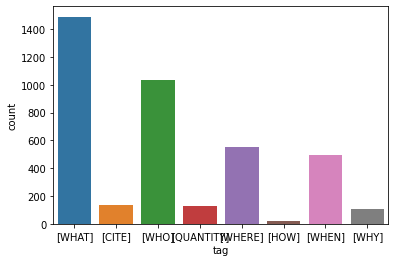

In [15]:
sns.countplot(x=df['tag'])
plt.show()

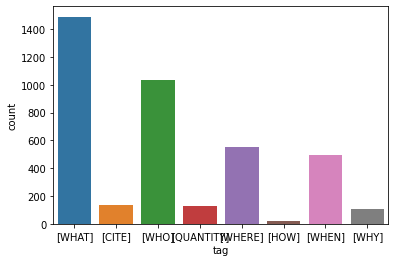

In [96]:
sns.countplot(x=df['tag'])
plt.show()

In [16]:
%%time
tags_how = Tags(how_sudo)
df_how = tags_how.apply()

CPU times: user 22.2 s, sys: 24 ms, total: 22.2 s
Wall time: 22.2 s


In [17]:
%%time
tags_why = Tags(why_sudo)
df_why = tags_why.apply()

CPU times: user 8.27 s, sys: 16 ms, total: 8.28 s
Wall time: 8.29 s


In [18]:
df_why['tag'].value_counts()

[WHY]         110
[WHAT]        108
[WHERE]        25
[WHO]          16
[HOW]          13
[QUANTITY]      3
[WHEN]          1
Name: tag, dtype: int64

In [19]:
%%time
tags_where = Tags(where_sudo)
df_where = tags_where.apply()

CPU times: user 2min 44s, sys: 208 ms, total: 2min 44s
Wall time: 2min 44s


In [20]:
df_where['tag'].value_counts()

[WHERE]       4685
[WHAT]        1182
[WHO]          140
[WHY]           23
[WHEN]          15
[HOW]           10
[QUANTITY]       8
Name: tag, dtype: int64

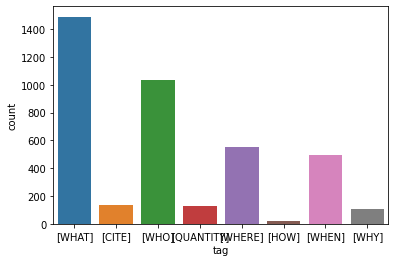

In [21]:
sns.countplot(x=df['tag'])
plt.show()

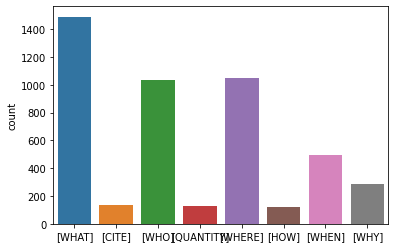

In [22]:
sns.countplot(x=pd.concat((df['tag'], pd.Series(['[HOW]']*100 + ['[WHY]']*180 + ['[WHERE]']*500))))
plt.show()

In [23]:
df_how['tag'].value_counts()

[WHAT]        469
[HOW]          80
[WHY]          58
[WHO]          26
[WHERE]        20
[QUANTITY]      2
[WHEN]          2
Name: tag, dtype: int64

In [24]:
sudo_del = ['연방대법원이 연방법률을 가차없이 위헌 판결을 내려 입법하는 행위를 뭐라고 해?', '책 어떻게 우리들의 관념을 명석하게 만드는가라는 주제의 책은?', '왕지네는 어떻게 난생인가?', '군세가 적에게 미치지 못한데다가 식수마저 끊기어 어떻게 해갈하였는가?', "'누설전류(2)' 상태에서도 정보처리가 가능한 초절전 3진법 반도체 기술은 기존의 어떤 방식보다 계산 속도가 1,000배 이상 빠르고 소비전력도 적어 반도체 칩을 보다 작게 만들 수 있다는 장점이 존재하였는가?", '인디언 법의 입법화가 추진된 광대한 토지와 자원에 대한 요구 때문에 지정된 것은?', '가토 다쓰야는 왜 나는 한국에 승리하였나. 박근혜 정권과의 500일 전쟁이라는 책에서 대한민국은 대통령과 국민 감정에 따라 법이 어떻게 된다고 했어?']

In [25]:
df_sudo = pd.concat((df, 
                     df_how[(df_how['tag']=="HOW") | (df_how['tag']=="WHY")],
                     df_why[(df_why['tag']=="HOW") | (df_why['tag']=="WHY")],
                     df_where[(df_where['tag']=="HOW") | (df_where['tag']=="WHY")],
                     df_where[df_where['tag']=="WHERE"].reset_index(drop=True)[:500]))

In [26]:
df_new = df_sudo[~df_sudo['question'].str.contains("|".join(sudo_del))].reset_index(drop=True)


/opt/conda/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [27]:
df_new.to_csv("/opt/ml/code2/data/train_new_tag.tsv", header=None, index=False, sep='\t')

In [28]:
%%time
tags_valid = Tags(valid_dataset)
df_valid = tags_valid.apply()

CPU times: user 6.91 s, sys: 16 ms, total: 6.92 s
Wall time: 6.93 s


In [29]:
df_valid['tag'].value_counts()

[WHAT]        103
[WHO]          52
[WHERE]        36
[WHEN]         25
[CITE]         10
[WHY]           8
[QUANTITY]      6
Name: tag, dtype: int64

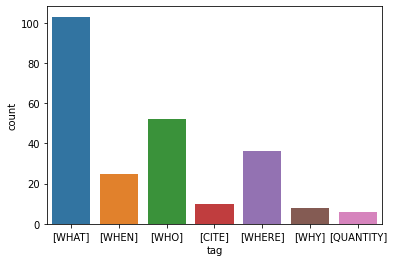

In [30]:
sns.countplot(x=df_valid['tag'])
plt.show()

In [31]:
df_valid.to_csv("/opt/ml/code2/data/valid_tag.tsv", header=None, index=False, sep='\t')

In [160]:
df_new.to_csv("/opt/ml/code2/data/train_new_tag.tsv", header=None, index=False, sep='\t')

In [208]:
df_test = pd.DataFrame(test_dataset['question'], columns=['question'])
df_test['tag'] = None
df_test.to_csv("/opt/ml/code2/data/test_tag.tsv", header=None, index=False, sep='\t')

In [189]:
test_tag = pd.read_csv("/opt/ml/code2/data/submission.csv")
test_tag = '[' + pd.Series(le.inverse_transform(test_tag['tag'])) + ']'
test_tag.to_csv("/opt/ml/code2/data/test_tag.tsv", header=None, index=False)

In [226]:
test_tag = pd.read_csv("/opt/ml/code2/data/submission.csv")
test_tag = '[' + pd.Series(le.inverse_transform(test_tag['tag'])) + ']'
test_tag.to_csv("/opt/ml/code2/data/test_tag.tsv", header=None, index=False)

In [109]:
df_valid = pd.DataFrame(valid_dataset['question'], columns=['question'])
# df_valid['tag'] = None
# df_valid.to_csv("/opt/ml/code2/data/valid_tag.tsv", header=None, index=False, sep='\t')


In [227]:
valid_tag = pd.read_csv("/opt/ml/code2/data/submission_valid.csv")
valid_tag = '[' + pd.Series(le.inverse_transform(valid_tag['tag'])) + ']'
valid_tag.to_csv("/opt/ml/code2/data/valid_tag.tsv", header=None, index=False)

In [72]:
tag_name = 'train_korquad1_dummy_sudo_bm25_6or7'
sudo_tag = pd.read_csv(f"/opt/ml/code2/prediction/{tag_name}_tag.csv")
# sudo_tag = '[' + pd.Series(le.inverse_transform(sudo_tag['tag'])) + ']'
# sudo_tag.to_csv("/opt/ml/code2/data/valid_tag.tsv", header=None, index=False)

In [85]:
label_decoder = {0: '[WHO]', 1: '[WHEN]', 2: '[WHERE]', 3: '[WHAT]', 4: '[HOW]', 5: '[WHY]', 6: '[QUANTITY]', 7: '[CITE]'}
sudo_tag['tag'].apply(lambda x: label_decoder[x])

0      [WHERE]
1        [WHO]
2        [WHO]
3        [WHO]
4       [WHEN]
        ...   
297     [WHAT]
298    [WHERE]
299      [WHO]
300     [WHAT]
301      [WHO]
Name: tag, Length: 302, dtype: object

In [42]:
load_from_disk('/opt/ml/code2/data/sudo/DUMMY')['question']

['각 측에서 주장된 포로교환 방법 중 선택된 것은?',
 '한국에서 음식을 올려놓을때 쓰이는 세간의 이름은 무엇인가요?',
 '미자르는 무엇의 일부인가?',
 '해안포를 정착해 해안을 방어하기 위해 건설한 것은?',
 '찰스 2세가 국내로 돌아오기 전에 있던 국가는?',
 '나카무라 번이 메이지 정부에 굴복하게 된 결투의 이름은 무엇인가요?',
 '예수의 테오토코스에 대해 부정적으로 인식했던 인물은?',
 '윤치호가 사촌동생을 통해 만나려고 했던 인물은?',
 '홉베마의 스승은 누구인가요?',
 '슈타우펜베르크는 들 것에 실려나온 사람이 무엇을 덮고 있는 것을 보고 히틀러의 죽음을 단정했나?',
 '아즈마의 초기 명칭은?',
 '경찰은 어떤 기관의 GPS를 이용하여 오원춘을 체포할 수 있었나요?',
 '자미토프가 개혁을 강행하기 위해 설립한 사병 집단은?',
 '드레이어 감독이 잔 다르크에 비유한 사람은?',
 '교전 당사자에 대한 전쟁 범죄 심판시 판단 기준이 되는 법은?',
 '단공류가 일반 포유류와 다르다는 것을 알 수 있는 신체 부위는?',
 '카쿠와 로브 루치의 현재 신분은?',
 '출혈성 천연두 초기와 말기 환자 모두에게 증가하는 물질은?',
 '사라스테의 후임은 누구인가?',
 '미자가 일을 때려친 것은 누구 때문인가?',
 '사이트에 올라오는 콘텐츠를 검열하는 주체는 누구인가?',
 '가트나는 2020년에 사물 인터넷 기술을 사용하는 사물은 몇 개일거라 예측했나?',
 '대원씨아이가 어떤 회사와 계약하여 한국에서 뉴타입을 출간할 수 있었나?',
 '태풍 초이완의 경보는 어떤 순간부터 풀렸는가?']

In [ ]:
'이','가','께서','에서','을','를','에','에게','께','에서','에게서','한테서','에서', '로','으로','으로서','의','과','와','하고','보다', '처럼', '만큼', '같이','아','야','이여','여','이시여','시여', '만','도','은','는','이','가','조차', '마저', '까지', '부터', '이나','나', '이나마','나마','이라도','라도', '이야','야', '이라야','라야'

In [35]:
pd.read_csv('/opt/ml/code2/prediction/test_tag.csv')['tag']

0          [WHAT]
1          [WHAT]
2          [CITE]
3      [QUANTITY]
4      [QUANTITY]
          ...    
595        [WHAT]
596        [CITE]
597       [WHERE]
598    [QUANTITY]
599        [WHAT]
Name: tag, Length: 600, dtype: object

In [64]:
list(test_dataset['question'] + pd.read_csv('/opt/ml/code2/prediction/test_tag.csv')['tag'])

["유령'은 어느 행성에서 지구로 왔는가?[WHAT]",
 '용병회사의 경기가 좋아진 것은 무엇이 끝난 이후부터인가?[WHAT]',
 '돌푸스에게 불특정 기간동안 하원이 잠시 쉬는 것을 건의 받았던 인물은?[WHO]',
 '마오리언어와 영어, 뉴질랜드 수화를 공식 언어로 사용하는 나라는?[WHERE]',
 '디엔비엔푸 전투에서 보응우옌잡이 상대한 국가는?[WHERE]',
 '단공류가 일반 포유류와 다르다는 것을 알 수 있는 신체 부위는?[WHAT]',
 '상류 부르주아의 정치 독점을 불러일으킨 체계는?[WHAT]',
 '아시노 호가 만들어진 원인은 무엇인가?[WHY]',
 '흉년이 발생하고 곳곳에 난이 일어났던 시기는?[WHEN]',
 '급전궤도는 보통 무엇으로 만들어져 있는가?[WHAT]',
 '클레어에게 오세아닉 815편을 타라고 말한 사람의 이름은?[WHO]',
 '제6군이 18일 동안이나 대기해야 했던 장소는?[WHERE]',
 '누가 시장으로 선출되면서 트랜짓 시티 계획안이 불발되었나?[WHO]',
 '1차 대각성 운동이 일어나는데 큰 영향을 끼친 설교는 어디서 진행되었는가?[WHERE]',
 '괴수로부터 메구밍을 구해준 사람은 누구인가?[WHO]',
 '슈파이어 대성당 2차 축조시에 가장 우선순위로 고려했던 천장 건축 방식은?[WHAT]',
 '통대를 뽑을 수 있었던 주체는 누구인가?[WHO]',
 '이유립씨가 1970년대 중반에 본인의 글을 기고하기 시작한 곳은?[WHERE]',
 '미군이 충원되지 않으면 서울이 전쟁 시작 후 2주만에 함락될 것이라 밝힌 문서는?[WHAT]',
 '임경업 장군이 도를 닦은 곳으로 알려진 곳은?[WHERE]',
 '화재에서 인종을 구한 공으로 귀인으로 직위가 오른 사람은?[WHO]',
 '초등학생 일기검사의 인권침해 여부를 판단하는 주체는?[WHAT]',
 '콘스탄티누스가 군사 4만 명을 이끌고 침범한 나라는?[WHERE]',
 '불보살이 천도할 대상은?[WHO]',
 '루돌로지스트들이 게임에서 가장 주된 것이라 주

In [46]:
temp = pd.read_csv('/opt/ml/code2/prediction/tdk12_tag.csv')['tag']

In [53]:
tag_idx = dict()
tag=['[CITE]', '[HOW]', '[QUANTITY]', '[WHAT]', '[WHEN]', '[WHERE]', '[WHO]', '[WHY]']
for t in tag:
    tag_idx[t[1:-1]] = temp[temp == t].index.tolist()

In [61]:
pd.Series(load_from_disk('/opt/ml/code2/data/sudo/tdk12')['question'])[tag_idx['CITE']].tolist()

['현대적 인사조직관리의 시발점이 된 책은?',
 '권번에서 요릿집에 제공한 기생 명부의 이름은?',
 '많은 갈등을 불러온 툴민의 책은?',
 '각절마다 미롱통 소리가 나오는 노래는?',
 '가수 이난영의 노래 중 기념비까지 세워진 것은?',
 '쌍곡 기하학 모형이 처음 등장한 책은?',
 '일반고 슬럼화 문제를 해결하기 위해 교육청에서 내세운 정책 슬로건은?',
 '국문과 역사를 가르치던 곳에서 민족의지의 격려를 위해 불렀던 노래는 무엇인가?',
 '동양의 문화적 요소를 가장 잘 활용한 타란티노의 작품은?',
 '판스워스 교수가 이전 배달원에 대해 한 대사는?',
 '돔 모양의 천막 지붕은 무엇을 모티브로 한 디자인인가요?',
 '『성련선』 내용에 따르면, 대전시에서 UFO로 인식되어지는 물체는?',
 '네덜란드 작가들이 자국의 황금기를 비유한 말은?',
 '당사자는 항소심에 있어서 새로운 사실자료를 제출할 수 있다는 의미의 용어는?',
 '에런 크루거는 위미르를 무엇이라 주장했나?',
 '“마님이 된 하녀”가 나머지 부분과 분리되기전 작품의 이름은?',
 '이자나미의 죽음이 나와있는 책은?',
 '크릭이 과학과 종교의 연결성을 언급했던 도서는?',
 '텔레비전 음악회에서 가수 김연자가 부른 노래는?',
 '조프루아가 여러 학자들이 발표한 동물 구조의 유사성 개념을 참고해 만든 논문은?',
 '포도주 블라인드 테스트를 소재로 만든 영화의 제목은?',
 '냉전 이후 여러 분야에서 상대적 발전을 지속한 시대를 일컫는 용어는?',
 '《나니아 연대기》시리즈 중 시간 설정이 가장 먼저인 작품의 이름은?',
 '윤치호가 일부 독립운동 지도자들로부터 비난 받았던 일기의 내용은?',
 '에포케의 이유를 제시한 책은?',
 '3년간 레논이 부인과 떨어져 지낸 시기를 뜻하는 말은?',
 '윤치호가 서양인을 높게 평가하면서 사용한 단어는?',
 '아오테아로아는 보통 뭐라고 해석하는가?',
 '프랑켄슈타인과 앙리 관계를 알 수 있는 노래는?',
 '사탄이 따뜻한 마음을 가진 

In [44]:
name = 'tdk12'
list(load_from_disk(f'/opt/ml/code2/data/sudo/{name}')['question'] + pd.read_csv(f'/opt/ml/code2/prediction/{name}_tag.csv')['tag'])

['대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?[WHAT]',
 '현대적 인사조직관리의 시발점이 된 책은?[CITE]',
 '강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?[WHO]',
 '11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?[WHAT]',
 '명문이 적힌 유물을 구성하는 그릇의 총 개수는?[QUANTITY]',
 '카드모스의 부하들이 간 곳에는 무엇이 있었는가?[WHAT]',
 '관우를 불태워 죽이려한 사람 누구인가?[WHO]',
 '참호 속에 무기와 장비를 버리고 도주한 집단은?[WHAT]',
 '제2차 세계 대전에 참전하여 사망한 자식은?[WHO]',
 '고려 공민왕이 처가 식구들과 아내와 함께 피신처로 삼은 마을은?[WHERE]',
 '정여창은 어떻게 죽었나?[HOW]',
 '아멜리아는 빅토르의 직업을 무엇으로 착각하나요?[WHAT]',
 '우핑가스 왕조의 이름은 어디서 유래하였나?[WHERE]',
 '장면이 한국으로 돌아온 년도는?[WHEN]',
 '유대교의 지나친 차별을 타파하려한 사람은?[WHO]',
 '권번에서 요릿집에 제공한 기생 명부의 이름은?[CITE]',
 '영국군 약 42만명의 사상자가 발생한 전투가 시작된 연도는?[WHEN]',
 '웨이크필드가 15번째 시즌에 활약한 팀의 이름은?[WHAT]',
 '김상옥이 종로경찰서에 폭탄을 던진 직후 피신한 곳은?[WHERE]',
 '윤치호가 극찬했던 조선시대의 인물은 누구인가요?[WHO]',
 '항우가 진나라를 멸하면서 조왕 헐은 어디로 이동했는가?[WHERE]',
 '30일에 한달 연장 근무를 신청하는 병사가 상금으로 받게 되는 금액은?[QUANTITY]',
 '슈만이 미군에게 포로로 잡혔던 년도는?[WHEN]',
 '김건의 할아버지가 세운 학교는?[WHERE]',
 '뇌에 탈피 신호를 보내는 부위는?[WHAT]',
 '툴민은 ≪코스모폴리스≫에서 근대과학과 무엇에 대해 비평하나요?[WHAT]',
 '아테네와 파트라간의 거리는?[QUANTIT

In [135]:
list(df_how[df_how['tag']=='HOW']['question'])

['현대 사회에서 통계는 어떤 방법으로 연구되는가?',
 '어떤 함수의 증가 양상을 다른 함수와의 비교로 표현하는 수론과 해석학의 방법이 뭐야?',
 '언어 계통이 정립되는데 어떤 방법이 사용돼?',
 '한국에서는 Zz가 어떻게 불려?',
 '마리오는 어떻게 방해 아이템을 피할 수 있어?',
 '미리 알려진 두 판단에서 그것들과는 다른 하나의 새로운 판단으로 이끄는 추론 방법을 뭐라고 해?',
 '현재 쓰이고 있는, 식물의 대체적인 모양이나 성질을 상상할 수 있는 방법의 이름은?',
 '암의 치료를 위한 화학물질과 사용 방법을 뭐라고 해?',
 '마르틴 크네저, 한스폴커 니마이어는 어떤 방식으로 정수 계수 이차 형식을 분류했어?',
 '한국학의 주요 연구 방법이 뭐야?',
 '연방대법원이 연방법률을 가차없이 위헌 판결을 내려 입법하는 행위를 뭐라고 해?',
 '심리학적 지식이 있는 자가 구매동기를 어떻게 판단하지?',
 '위 법원은 대일리가 개럿에 대한 신체 접촉 가능성을 알았거나 이해했다면 사건을 어떻게 처리했는가?',
 '일부 국가에서 사회적 정서에 맞지 않는 노래를 금지곡으로 지정하거나 악보 판매를 어떻게 하기도 하지?',
 '토스카의 새끼를 발견한 사육사들은 어떻게 하였는가?',
 '마라타 제국의 시조인 시바지 보살레가 고안한 기구에서 나오는 문서와 행정명령들은 모두 어떻게 쓰여졌는가?',
 '웁실론 b는 어떤 방법으로 관찰되었어?',
 '가정을 선택하는 추론의 한 방법이 뭐야?',
 '운디드니 학살은 현재 어떻게 평가되고 있어?',
 '진보주의 교육에서는 어떤 방법을 사용했어?',
 '1832년 선거법 개정 이후 나타난 발본파는 어떻게 나뉘어져?',
 '책 어떻게 우리들의 관념을 명석하게 만드는가라는 주제의 책은?',
 '퍼스가 주장한 신념은 어떤 방법이라고 주장했어?',
 '클로드 레비스트로스가 쓴 슬픈 열대에서 발견할 수 있는 방법의 원형은?',
 '월드 오브 구 게임에서 구들을 어떻게 내보내야 해?',
 '기계를 어떻게 사용하면 주부를 해방시킬 

In [ ]:
# how
'연방대법원이 연방법률을 가차없이 위헌 판결을 내려 입법하는 행위를 뭐라고 해?'
'책 어떻게 우리들의 관념을 명석하게 만드는가라는 주제의 책은?'
'왕지네는 어떻게 난생인가?'
'군세가 적에게 미치지 못한데다가 식수마저 끊기어 어떻게 해갈하였는가?'
"'누설전류(2)' 상태에서도 정보처리가 가능한 초절전 3진법 반도체 기술은 기존의 어떤 방식보다 계산 속도가 1,000배 이상 빠르고 소비전력도 적어 반도체 칩을 보다 작게 만들 수 있다는 장점이 존재하였는가?"

# why
'인디언 법의 입법화가 추진된 광대한 토지와 자원에 대한 요구 때문에 지정된 것은?'
'가토 다쓰야는 왜 나는 한국에 승리하였나. 박근혜 정권과의 500일 전쟁이라는 책에서 대한민국은 대통령과 국민 감정에 따라 법이 어떻게 된다고 했어?'

# where
'노래 소는 어디에서 종종 사용돼?',
'리비우스에 따르면 아벤티노 언덕은 왕정 말기까지 어디까지 존속했을 가능성이 큰가?'
'김재규의 아들은 법관이 되지 않고 어디의 설립 초기에 합류했는가?'

In [597]:
list(place['question'][place['tag'].isnull()])

['남녀가 키스를 나눈 마을 이름은?',
 '한국 대 멕시코 경기에서 선제골을 넣은 쪽은?',
 '7월 4일 북한군이 전투를 벌인곳은?',
 '사패산 송추계곡에서 발원한 하천의 이전 명칭은?']

In [618]:
df[df['question'].str.contains('무엇')]['tag'].value_counts()

WHAT        335
WHY          38
CITE         25
WHERE         6
HOW           2
WHO           2
QUANTITY      1
Name: tag, dtype: int64

In [ ]:
의미 비유 뜻 표현 한 - 말

In [ ]:
생각 부르는 사용한 부른

In [754]:
df[df['question'].str.split().str[-1].str.contains('글')]

,question,answer,tag
76,에릭 레이먼드의 자유 소프트웨어 철학을 대변하는 글은?,〈성당과 시장〉(The Cathedral and the Bazaar),CITE
544,강중인이 경제사범을 비판하며 국민의 일대수치라 표현한 글은?,최근의 반도의 경제사범 ­국민의 신경제 윤리의 파악을 위하여­,etc
2910,주종찬이 그의 손에서 나오는 피로 쓴 글자는?,‘일심(一心)’,CITE


In [741]:
pd.DataFrame(df[df['tag']=='CITE']['question'].str.split().str[-1].value_counts()).reset_index()[40:60]

,index,question
40,무엇이었나?,1
41,언급하였나?,1
42,지니는가?,1
43,글자는?,1
44,있나요?,1
45,도서는?,1
46,대사는?,1
47,주장했나?,1
48,통명은?,1
49,전술은?,1


In [687]:
pd.DataFrame(df[df['tag']=='etc']['question'].str.split().str[-1].value_counts()).reset_index()[40:50]

,index,question
40,책은?,3
41,기준은?,3
42,장수는?,3
43,불상은?,3
44,역은?,3
45,악기는?,3
46,받았나?,3
47,만들어졌는가?,3
48,정체는?,3
49,나뉘나요?,3


In [323]:
df[df['tag'] == 'WHERE']

,question,answer,tag
9,고려 공민왕이 처가 식구들과 아내와 함께 피신처로 삼은 마을은?,왕대마을,WHERE
18,김상옥이 종로경찰서에 폭탄을 던진 직후 피신한 곳은?,삼판동,WHERE
20,항우가 진나라를 멸하면서 조왕 헐은 어디로 이동했는가?,대나라,WHERE
23,김건의 할아버지가 세운 학교는?,사립 김노인 고등학교,WHERE
65,대만에서 단일 태풍 강우량 신기록을 남긴 지역은?,핑둥현,WHERE
...,...,...,...
3918,개인적 요소와 상황적 요소로 설명되는 내집단 구성원의 행동 양식은 어디에 보고돼있나?,상호집단관계에 관한 문헌,WHERE
3921,의무교육과정이 끝나고도 아일랜드어를 쓰는 지역은?,게일타흐트,WHERE
3922,밤이 되면 공기가 위로 올라가는 곳은 육지와 바다 중 어디인가?,바다,WHERE
3931,1379년에 이탈리아의 주요 거점지로 인정받았던 장소는?,베니스,WHERE


In [171]:
df.to_csv('question_type.csv', index=False)

In [202]:
se = Pororo(task='sentvec', lang='ko')

In [250]:
embedding = np.array([se(df['question'][i]) for i in range(len(df))])
embedding.shape

(3952, 768)

In [253]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df['question'])
tfidf.shape

(3952, 15306)

In [276]:
from sklearn.decomposition import TruncatedSVD
clf = TruncatedSVD(n_components=768)
Xpca = clf.fit_transform(tfidf)
Xpca.shape

(3952, 768)

In [234]:
# from sklearn.manifold import TSNE
# X_pca = TSNE(n_components=2).fit_transform(tfidf)
# X_pca.shape

In [84]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [278]:
X_pca.shape

(3952, 2)

In [282]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(embedding*Xpca, df['answer'])
train_lda = lda.transform(Xpca)
train_lda.T[0].shape

(3952,)

In [239]:
lda2 = LinearDiscriminantAnalysis(n_components=2)
lda2.fit(Xpca, df['answer'])
train_lda2 = lda2.transform(Xpca)
train_lda2.T[0].shape

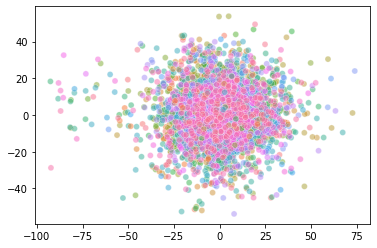

In [283]:
sns.scatterplot(x=train_lda.T[0], y=train_lda.T[1], hue=df['answer'], legend=None, alpha=0.5)
plt.show()

In [104]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=np.array(df['question'].apply(mecab.morphs)), vector_size=100, window=5, min_count=1, workers=4)

In [91]:
import numpy as np

In [105]:
model.wv.vectors.shape

(9531, 100)

In [98]:
len(df['question'])

3952

In [ ]:
df_new